# 6.3 Padding and Stride
In the previous example of Fig. 6.2.1, our input had both a height and width of 3 and our convolution kernel had both a height and width of 2, yielding an output representation with dimension
2 × 2. As we generalized in Section 6.2, assuming that the input shape is nh × nw and the convolution kernel shape is $k_h × k_w$, then the output shape will be $(n_h − k_h + 1) × (n_w − k_w + 1)$. Therefore,
the output shape of the convolutional layer is determined by the shape of the input and the shape
of the convolution kernel.

In several cases, we incorporate techniques, including padding and strided convolutions, that affect the size of the output. As motivation, note that since kernels generally have width and height
greater than 1, after applying many successive convolutions, we tend to wind up with outputs that
are considerably smaller than our input. If we start with a $240 × 240$ pixel image, 10 layers of $5 × 5$
convolutions reduce the image to $200 × 200$ pixels, slicing off 30% of the image and with it obliterating any interesting information on the boundaries of the original image. *Padding* is the most
popular tool for handling this issue.

In other cases, we may want to reduce the dimensionality drastically, e.g., if we find the original
input resolution to be unwieldy. Strided convolutions are a popular technique that can help in these
instances.

## 6.3.1 Padding
As described above, one tricky issue when applying convolutional layers is that we tend to lose
pixels on the perimeter of our image. Since we typically use small kernels, for any given convolution, we might only lose a few pixels, but this can add up as we apply many successive convolutional layers. One straightforward solution to this problem is to add extra pixels of filler around
the boundary of our input image, thus increasing the effective size of the image. Typically, we
set the values of the extra pixels to zero. In Fig. 6.3.1, we pad a $3 × 3$ input, increasing its size to
$5×5$. The corresponding output then increases to a $4×4$ matrix. The shaded portions are the first
output element as well as the input and kernel tensor elements used for the output computation:
$0 × 0 + 0 × 1 + 0 × 2 + 0 × 3 = 0$.

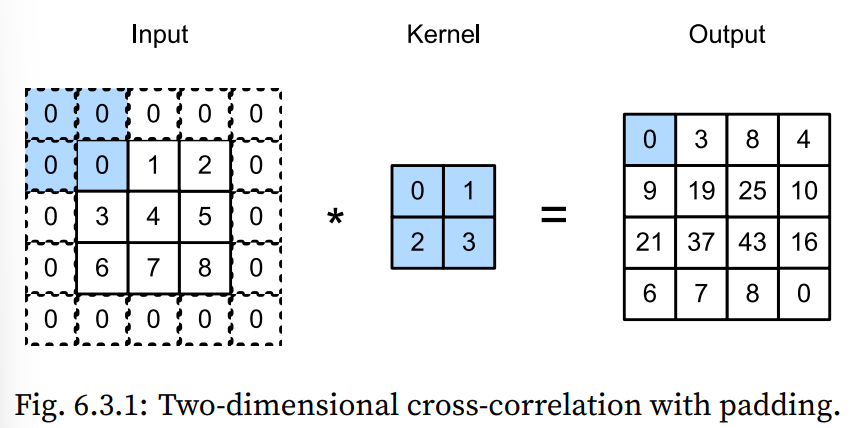

In general, if we add a total of ph rows of padding (roughly half on top and half on bottom) and
a total of pw columns of padding (roughly half on the left and half on the right), the output shape
will be

$$(n_h − k_h + p_h + 1) × (n_w − k_w + p_w + 1). (6.3.1)$$

This means that the height and width of the output will increase by ph and pw, respectively.
In many cases, we will want to set $p_h = k_h − 1$ and $p_w = k_w − 1$ to give the input and output the
same height and width. This will make it easier to predict the output shape of each layer when
constructing the network. Assuming that kh is odd here, we will pad $ph/2$ rows on both sides of
the height. If kh is even, one possibility is to pad $⌈ph/2⌉$ rows on the top of the input and $⌊ph/2⌋$
rows on the bottom. We will pad both sides of the width in the same way.

CNNs commonly use convolution kernels with odd height and width values, such as 1, 3, 5, or 7.
Choosing odd kernel sizes has the benefit that we can preserve the spatial dimensionality while
padding with the same number of rows on top and bottom, and the same number of columns on
left and right.

Moreover, this practice of using odd kernels and padding to precisely preserve dimensionality
offers a clerical benefit. For any two-dimensional tensor X, when the kernelʼs size is odd and the
number of padding rows and columns on all sides are the same, producing an output with the same
height and width as the input, we know that the output $Y[i, j]$ is calculated by cross-correlation
of the input and convolution kernel with the window centered on $X[i, j]$.

In the following example, we create a two-dimensional convolutional layer with a height and width
of 3 and apply 1 pixel of padding on all sides. Given an input with a height and width of 8, we find
that the height and width of the output is also 8.

In [1]:
use strict;
use warnings;
use Data::Dump qw(dump);
use AI::MXNet qw(mx);
use AI::MXNet::Gluon qw(gluon);

# For convenience, we define a function to calculate the convolutional layer.
# This function initializes the convolutional layer weights and performs
# corresponding dimensionality elevations and reductions on the input and
# output
sub comp_conv2d{
    my ($conv2d, $X) = @_;
    $conv2d->initialize();
    # Here (1, 1) indicates that the batch size and the number of channels
    # are both 1
    $X = $X->reshape([1, 1, $X->shape->[0], $X->shape->[1]]);

    my $Y = $conv2d->($X);
    # Exclude the first two dimensions that do not interest us: examples and
    # channels
    return $Y->reshape(mx->nd->array($Y->shape)->slice([2,-1])->asarray)
}
# Note that here 1 row or column is padded on either side, so a total of 2
# rows or columns are added

my $conv2d_1 = gluon->nn->Conv2D(1, kernel_size=>3, padding=>1);
my $X = mx->nd->random->uniform(shape=>[8, 8]);
print dump comp_conv2d($conv2d_1, $X)->shape;

[8, 8]

1

When the height and width of the convolution kernel are different, we can make the output and
input have the same height and width by setting different padding numbers for height and width.

In [2]:
# Here, we use a convolution kernel with a height of 5 and a width of 3. The
# padding numbers on either side of the height and width are 2 and 1,
# respectively
my $conv2d_2 = gluon->nn->Conv2D(1, kernel_size=>[5, 3], padding=>[2, 1]);
print dump comp_conv2d($conv2d_2, $X)->shape;

[8, 8]

1

## 6.3.2 Stride
When computing the cross-correlation, we start with the convolution window at the top-left corner of the input tensor, and then slide it over all locations both down and to the right. In previous
examples, we default to sliding one element at a time. However, sometimes, either for computational efficiency or because we wish to downsample, we move our window more than one element
at a time, skipping the intermediate locations.

We refer to the number of rows and columns traversed per slide as the stride. So far, we have used
strides of 1, both for height and width. Sometimes, we may want to use a larger stride. Fig. 6.3.2
shows a two-dimensional cross-correlation operation with a stride of 3 vertically and 2 horizontally. The shaded portions are the output elements as well as the input and kernel tensor elements
used for the output computation: $0 × 0 + 0 × 1 + 1 × 2 + 2 × 3 = 8, 0 × 0 + 6 × 1 + 0 × 2 + 0 × 3 = 6$.
We can see that when the second element of the first column is outputted, the convolution window slides down three rows. The convolution window slides two columns to the right when the
second element of the first row is outputted. When the convolution window continues to slide
two columns to the right on the input, there is no output because the input element cannot fill the
window (unless we add another column of padding).

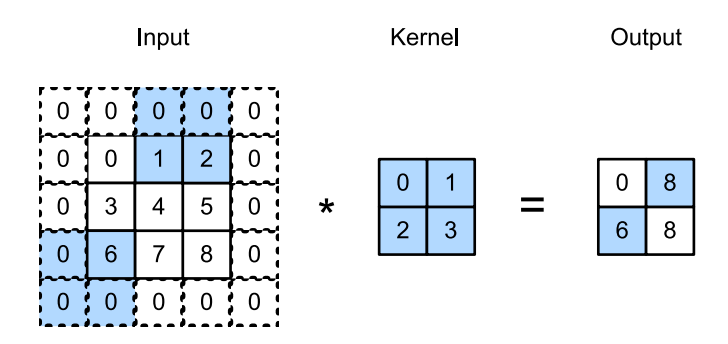

In general, when the stride for the height is sh and the stride for the width is sw, the output shape
is

$$⌊(n_h − k_h + p_h + s_h)/s_h⌋ × ⌊(n_w − k_w + p_w + s_w)/s_w⌋. (6.3.2)$$

If we set $p_h = k_h − 1$ and $p_w = k_w − 1$, then the output shape will be simplified to $⌊(n_h + s_h − 1)/s_h⌋ × ⌊(n_w + s_w − 1)/s_w⌋$. Going a step further, if the input height and width are divisible by
the strides on the height and width, then the output shape will be $(n_h/s_h) × (n_w/s_w)$.
Below, we set the strides on both the height and width to $2$, thus halving the input height and width.

In [3]:
my $conv2d_3 = gluon->nn->Conv2D(1, kernel_size=>3, padding=>1, strides=>2);
print dump comp_conv2d($conv2d_3, $X)->shape;

[4, 4]

1

Next, we will look at a slightly more complicated example.

In [4]:
my $conv2d_4 = gluon->nn->Conv2D(1, kernel_size=>[3, 5], padding=>[0, 1], strides=>[3, 4]);
print dump comp_conv2d($conv2d_4, $X)->shape;

[2, 2]

1

For the sake of brevity, when the padding number on both sides of the input height and width are
ph and pw respectively, we call the padding $(p_h, p_w)$. Specifically, when $p_h = p_w = p$, the padding is $p$. When the strides on the height and width are sh and $s_w$, respectively, we call the stride $(s_h, s_w)$.
Specifically, when $s_h = s_w = s$, the stride is $s$. By default, the padding is $0$ and the stride is $1$.
In practice, we rarely use inhomogeneous strides or padding, i.e., we usually have $p_h = p_w$ and
$s_h = s_w$.
## Summary
* Padding can increase the height and width of the output. This is often used to give the output the same height and width as the input.
* The stride can reduce the resolution of the output, for example reducing the height and width of the output to only $1/n$ of the height and width of the input (n is an integer greater than 1).
* Padding and stride can be used to adjust the dimensionality of the data effectively.